### 1. Imports

In [63]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json

### 2. Initial Conditions and Constants

In [64]:
with open('starting_conditions.json', 'r') as f:
    data = json.load(f)

planet_info = data['planets']
m1, m2, m3 = planet_info['masses'] # masses
p1_i, p2_i, p3_i = planet_info['positions'] # 3d coords of starting positions
v1_i, v2_i, v3_i = planet_info['velocities']

# Create array for initial conditions, required for solve_ivp's differential equation function
initial_conditions = np.array([
    [p1_i, p2_i, p3_i],
    [v1_i, v2_i, v3_i]
]).ravel().astype(np.float64)

masses = np.array([m1, m2, m3]).astype(np.float64)

### 3. Defining First Order ODEs

In [65]:
def get_ode_system(
        t: float,
        y_vec: NDArray[np.float64],
        masses: NDArray[np.float64]
) -> NDArray[np.float64]:
    """
    Define the system of first order ODEs for `solve_ivp` for n-bodies.

    Args:
        t (float): Time (required by solve_ivp but not used here).
        y_vec (NDArray[np.float64]): 1D array of state variables.
        masses (NDArray[np.float64]): 1D array of masses for each body.

    Returns:
        NDArray[np.float64]: 1D array of derivatives corresponding to each element in `y_vec` (must be same length).
    """
    N = len(masses)
    positions = y_vec[:N * 3].reshape((N, 3)) # n-th row is position of n-th body
    velocities = y_vec[N * 3:].reshape((N, 3)) # n-th row is velocity of n-th body

    accelerations = np.zeros_like(positions)
    for i in range(N):
        for j in range(N):
            if i == j: # only calculate external forces by other bodies
                continue

            r_vector = positions[j] - positions[i]
            dist_cubed = np.linalg.norm(r_vector) ** 3
            accelerations[i] += masses[j] * r_vector / dist_cubed # element-wise summation of accelerations
    
    dp_dts = velocities
    dv_dts = accelerations
    return np.concatenate((dp_dts, dv_dts)).ravel()

### 4. Solving the Problem Numerically

In [66]:
t_i, t_f = 0.0, 10.0 # characteristic/dimensionless time
t_points = np.linspace(t_i, t_f, 1001)

solution = solve_ivp(
    fun=get_ode_system,
    t_span=(t_i, t_f),
    y0=initial_conditions,
    t_eval=t_points,
    args=(masses,) # additional arguments to pass to `fun` beyond time and initial conditions
)

### 5. Data Extraction and Plotting

In [67]:
# Prepare the solution data for plotting
N = len(masses)
solved_values = solution.y
num_timesteps = solved_values.shape[1]

position_values = solved_values[:3*N, :]
velocity_values = solved_values[3*N:, :]

# Each layer is the n-th body, each row is a dimension, and then each column is the position/velocity at a specific timestep
position_values.shape = (N, 3, num_timesteps)
velocity_values.shape = (N, 3, num_timesteps)

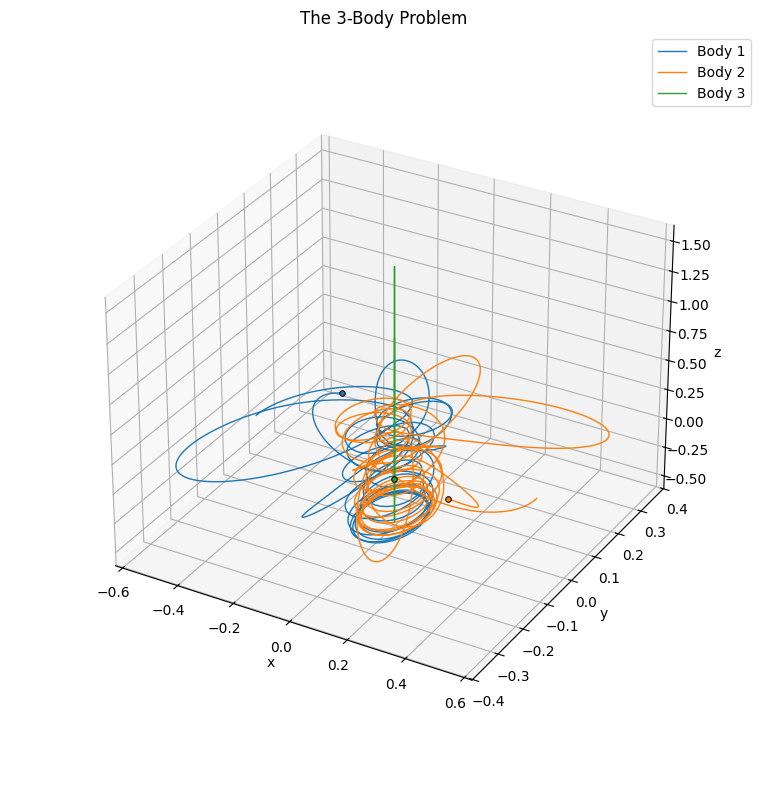

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from typing import cast

# Plot the data with matplotlib
fig = plt.figure(figsize=(10, 8))
ax = cast(Axes3D, fig.add_subplot(projection='3d'))

# Colors to cycle through (if many bodies)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Loop through each body to plot its tragectory
for i in range(N):
    color = colors[i % len(colors)]

    x_coords = position_values[i, 0, :]
    y_coords = position_values[i, 1, :]
    z_coords = position_values[i, 2, :]

    # Plot trajectory
    ax.plot(
        x_coords, y_coords, z_coords,
        color=color,
        label=f'Body {i + 1}',
        linewidth=1
    )

    # Plot end points
    ax.plot(
        x_coords[-1], y_coords[-1], z_coords[-1],
        marker='o',
        color=color,
        markersize=4,
        markeredgecolor='black',
        markeredgewidth=0.75
    )

ax.set_title("The 3-Body Problem")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect(None, zoom=0.85) #type: ignore

fig.tight_layout()

plt.legend()
plt.show()

### Plotting with Animations and Scaled Units
(in progress...)